### Proyecto Programación Avanzada: Estudio de la distribución del género Eucalyptus en la Comunidad Autónoma de Cantabria
#### Práctica 1: EDA
#### 1.1 Estudio de reflectividad en la Comunidad.

En esta práctica vamos a realizar un análisis exploratorio de datos para el género de eucaliptos, 
debido a que son una especie invasora en la península.

Partiremos de datos en formatos shape que consisten en la ubicacion comprobada de eucaliptos en la peninsula y en Cantabria, tanto en una capa de poligonos correspondiente al mapa forestal de España disponibles en: miteco.gob.es. Este mapa forestal ha sido depurado para obtener solo los poligonos que tienen especies de eucalipto. 
Asimismo se ha utilizado una capa de datos como puntos concretos de eucaliptos en la peninsula.  En el formato raster trabajaremos con imagenes Sentinel 2A, de nivel 2, por lo que no será necesario corregir reflectividades. Estas imagenes se descargan como una imagen en formato jp2 por cada banda, siendo un total de 13 bandas espectrales, y 13 imagenes por cuadrante. En la comunidad de cantabria hacen un total de 4 cuadrantes para cubrir el area entera por lo que será necesaria tanto una transformación en multiimagen como una composicion en mosaico para obtener la imagen con la que trataremos finalmente. Todo esto lo haremos un poco mas adelante.

Primero importaremos las librerias necesarias para este apartado.

In [7]:
import os
import getpass
import sys
import pandas as pd
import geopandas as gpd
import numpy as np
import xarray
import shapely
import matplotlib.pyplot as plt
import rasterio
import glob
import seaborn as sns
import tkinter as tk
import math

Ahora, solucionamos el problema con la librería PROJ y GDAL

In [6]:
usuario = getpass.getuser()

# os.environ['GDAL_DATA'] = f'/opt/anaconda3/envs/geoenv/share/gdal'
# os.environ['PROJ_LIB'] = f'/opt/anaconda3/envs/geoenv/share'

# en windows
os.environ['GDAL_DATA'] = f'C:\\Users\\{usuario}\\anaconda3\\envs\\advprog\\Library\\share\\gdal'
os.environ['PROJ_LIB'] = f'C:\\Users\\{usuario}\\anaconda3\\envs\\advprog\\Library\\share\\proj'

Ahora vamos a establecer las rutas principales en las que se encuentran los geodatos:
(Utilizamos de esta manera sys.argv para facilitar el uso del notebook.)

In [5]:
#sys.argv[1] = "C:\\Users\\angel\\Documents\\Programacion_avanzada\\practicas\\Geodatos\\" #Ángel
sys.argv[1] = "E:\\advprog\\p1\\Geodatos\\" #Edu

euc_points = sys.argv[1] + "eucaliptos_españa_puntos\\eucalyptus_points.csv"
euc_mfe = sys.argv[1] + "Eucaliptales_Cornisa_Cantabrica\\Eucaliptales_Cornisa_Cantabrica.shp"

Como ya hemos comentado, las imagenes en ráster, descargadas del portal oficial de Sentinel 2A, pero que se pueden encontrar en el enlace adjunto en el envio de la práctica, aparecen en imagenes independientes por cada banda, y para Cantabria, son 4 imagenes diferentes, por lo que lo primero es unir las bandas en imagenes multibanda,
y tras eso hacer un mosaico para obtener la imagen completa. Tras esto, queda una imagen con la zona cantabra en el centro, pero todo lo demas es información sin interés, que no queremos en nuestro estudio estadístico de la zona, por lo que querremos hacer un recorte de esta ultima imagen, con la forma de la comunidad autonoma de Cantabria.

Lo primero que vamos a hacer es seleccionar las rutas de las carpetas de las imagenes que queremos convertir a multibanda y mas adelante unir en un mosaico unico para su posterior analisis. Para ello tenemos dos opciones, introducirlas a mano, lo cual sirve bien para este caso concreto, o crear una herramienta que nos permita escoger las carpetas en las que se encuentran las imagenes. A continuación aparecen ambas opciones:


In [ ]:
# Esta primera opción genera un objeto llamado "rutas" y tras esto abre una ventana con tkinter
# que permite introducir la ruta de una carpeta navegando a traves de los directorios del usuario.
# Además permite eliminar rutas por si se introducen erroneamente, antes de añadirlas al objeto.

import tkinter as tk
from tkinter import filedialog
import os

rutas = []

def select_folder():
    folder_selected = filedialog.askdirectory(initialdir=os.path.expanduser("~"))
    if folder_selected:
        folder_selected = folder_selected.replace("/", "\\")  # Reemplazmos '/' por '\\' para evitar conflictos.
        rutas.append(folder_selected)
        update_listbox()

def update_listbox():
    listbox.delete(0, tk.END)
    for ruta in rutas:
        listbox.insert(tk.END, ruta)

def remove_selected():
    selected_index = listbox.curselection()
    if selected_index:
        rutas.pop(selected_index[0])
        update_listbox()

def finish_selection():
    root.destroy()

root = tk.Tk()
root.title("Seleccionar Carpetas")
root.geometry("500x400")

tk.Label(root, text="Selecciona una carpeta", font=("Arial", 12)).pack(pady=5)

button_select = tk.Button(root, text="Seleccionar Carpeta", command=select_folder, font=("Arial", 10))
button_select.pack(pady=5)

listbox = tk.Listbox(root, width=60, height=10)
listbox.pack(pady=5)

button_remove = tk.Button(root, text="Eliminar ruta seleccionada", command=remove_selected, font=("Arial", 10))
button_remove.pack(pady=5)

button_finish = tk.Button(root, text="Finalizar Selección", command=finish_selection, font=("Arial", 10))
button_finish.pack(pady=5)

root.mainloop()

La siguiente celda genera una lista con los fragmentos necesarios de las rutas de nuestras 4 imagenes que queremos transformar a multibanda.

In [6]:
#ruta1 = input("Introduzca la rutas de la carpeta que contiene las bandas en orden:")
#ruta2 = input("Introduzca la rutas de la carpeta que contiene las bandas en orden:")
#ruta3 = input("Introduzca la rutas de la carpeta que contiene las bandas en orden:")
#ruta4 = input("Introduzca la rutas de la carpeta que contiene las bandas en orden:")
ruta1 = "S2C_MSIL2A_20250219T111131_N0511_R137_T30TUN_20250219T152713.SAFE\\GRANULE\\L2A_T30TUN_A002395_20250219T111258\\IMG_DATA\\R20m"
ruta2 = "S2C_MSIL2A_20250219T111131_N0511_R137_T30TUP_20250219T152713.SAFE\\GRANULE\\L2A_T30TUP_A002395_20250219T111258\\IMG_DATA\\R20m"
ruta3 = "S2C_MSIL2A_20250219T111131_N0511_R137_T30TVN_20250219T152713.SAFE\\GRANULE\\L2A_T30TVN_A002395_20250219T111258\\IMG_DATA\\R20m"
ruta4 = "S2C_MSIL2A_20250219T111131_N0511_R137_T30TVP_20250219T152713.SAFE\\GRANULE\\L2A_T30TVP_A002395_20250219T111258\\IMG_DATA\\R20m"
rutas = []
rutas.append(ruta1)
rutas.append(ruta2)
rutas.append(ruta3)
rutas.append(ruta4)
rutas

['S2C_MSIL2A_20250219T111131_N0511_R137_T30TUN_20250219T152713.SAFE\\GRANULE\\L2A_T30TUN_A002395_20250219T111258\\IMG_DATA\\R20m',
 'S2C_MSIL2A_20250219T111131_N0511_R137_T30TUP_20250219T152713.SAFE\\GRANULE\\L2A_T30TUP_A002395_20250219T111258\\IMG_DATA\\R20m',
 'S2C_MSIL2A_20250219T111131_N0511_R137_T30TVN_20250219T152713.SAFE\\GRANULE\\L2A_T30TVN_A002395_20250219T111258\\IMG_DATA\\R20m',
 'S2C_MSIL2A_20250219T111131_N0511_R137_T30TVP_20250219T152713.SAFE\\GRANULE\\L2A_T30TVP_A002395_20250219T111258\\IMG_DATA\\R20m']

Lo siguiente genera las 4 imagenes multibanda en formato .tif en las distintas rutas. Y añade cada ruta, dentro del bucle, en un objeto llamado salidas_raster
que utilizaremos mas adelante. Es importante mencionar, que dependiendo de la opcion que hayamos utilizado para introducir las rutas, es posible que sea necesario modificar el primer caracter '#' en las lineas 3 y 4 de la celda siguiente.

In [ ]:
salidas_raster = []
for i, ruta in enumerate(rutas):
    #raster_files = sorted(glob.glob(ruta + "\\*.jp2")) # Para la primera opción.
    raster_files = sorted(glob.glob(sys.argv[1] + "imagenes/" + ruta + "/*.jp2")) # Esta linea para la segunda opcion.
    
    if not raster_files:
        print(f"No se encontraron archivos en {ruta}")
        continue
    
    bands = []
    with rasterio.open(raster_files[0]) as src:
        meta = src.meta.copy()
        meta.update({"count": len(raster_files), "driver": "GTiff"})
    
    for file in raster_files:
        with rasterio.open(file) as src:
            bands.append(src.read(1))
    
    stacked_array = np.stack(bands)
    output_tif = sys.argv[1] + "imagenes/" + ruta + "/salida/imagen_combinada_" + str(i+1) + ".tif"
    
    with rasterio.open(output_tif, "w", **meta) as dst:
        for j in range(stacked_array.shape[0]):
            dst.write(stacked_array[j], j + 1)
    salidas_raster.append(output_tif)
    print(f"Archivo guardado en: {output_tif}")


Ahora quedaría hacer el mosaico, con las rutas de las multiimagenes que acabamos de generar y añadir en el objeto salidas_raster.

In [ ]:
from rasterio.merge import merge

# Abrimos los archivos de salida
src_files_to_mosaic = [rasterio.open(file) for file in salidas_raster]

# Juntamos las imagenes con merge
mosaic, out_transform = merge(src_files_to_mosaic, method="first")  # "first" prioriza el primer píxel encontrado

# Copiamos los metadatos
out_meta = src_files_to_mosaic[0].meta.copy()
out_meta.update({
    "height": mosaic.shape[1],  
    "width": mosaic.shape[2],   
    "transform": out_transform  
})

# Guardamos la imagen final
output_tif = sys.argv[1] + "imagenes\\mosaico.tif"
with rasterio.open(output_tif, "w", **out_meta) as dest:
    for i in range(mosaic.shape[0]):  # (Para mantener el orden de las bandas)
        dest.write(mosaic[i], i + 1)

print(f"Mosaico guardado en: {output_tif}")

# Y cerrar los rasters
for src in src_files_to_mosaic:
    src.close()

Ahora quedaría hacer el recorte de la comunidad autónoma para ya tener los datos finales con los que queremos trabajar.

In [ ]:

# rutas
output_tif = sys.argv[1] + "imagenes\\mosaico.tif"
shapefile_path = sys.argv[1] + "shp_cantabria\\cantabria.shp"
output_path = sys.argv[1] + "resultados\\recorte_final.tif"


# Cargar shapefile
shapefile = gpd.read_file(shapefile_path)

# Abrir el ráster para saber su SRC
with rasterio.open(output_tif) as src:
    raster_crs = src.crs  # Obtener CRS del ráster

# Reproyección del shapefile al SRC del ráster si fuera necesario (en este caso lo es)
if shapefile.crs != raster_crs:
    shapefile = shapefile.to_crs(raster_crs)

# Convertir geometría a formato GeoJSON (con shapely)
geometries = [mapping(geom) for geom in shapefile.geometry]

# Abrir el ráster y recortar
with rasterio.open(output_tif) as src:
    out_image, out_transform = mask(src, geometries, crop=True, all_touched=True)

    out_meta = src.meta.copy()
    out_meta.update({
        "driver": "GTiff",
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform
    })

    # Guardar la nueva imagen
    with rasterio.open(output_path, "w", **out_meta) as dest:
        dest.write(out_image)

print(f" Recorte guardado en: {output_path}")

Ya teniendo nuestros datos preparados, podemos proceder a hacer el EDA.
A continuación vamos a generar graficos y estadisticas basicas de la imagen. Cabe mencionar que excluiremos el valor "0", ya que es el que tienen los pixeles que no forman parte de la Comunidad Autónoma de Cantabria. Primero generaremos una tabla de estadisticas básicas de la imagen, en la que mostraremos el maximo, minimo, media, desviacion estándar, y los maximos y minimos de los percentiles 2 y 98, por si hubiera algunos valores erróneos. 

Además vamos a generar una matriz de correlacion de las imagenes.

Despues vamos a generar las imagenes de cada una de las bandas en una composición blanco y negro, para los valores mas altos y bajos respectivamente. Esto nos dará una visión espacial general de las zonas en las que hay valores mas altos de reflectividad en las diferentes bandas.

Finalmente generaremos los histogramas de cada una de las bandas, para observar como se distribuyen los valores de reflectividad en cada una.

    Banda  Mínimo  Máximo        Media  Desviación estándar      P2      P98
0       1      72     209   115.971447            27.628403    82.0   180.00
1       2       1   20273  1740.411777          1388.414996  1094.0  7185.00
2       3     833   20524  1765.917765          1354.427364  1113.0  7080.00
3       4     952   19146  1935.370723          1259.230661  1216.0  6806.00
4       5     973   18224  1941.321641          1249.126698  1195.0  6705.74
5       6     396   17799  2438.288795          1251.062775  1370.0  7086.00
6       7     437   17701  3323.334751          1285.084449  1562.0  7234.00
7       8     512   17546  3604.010728          1305.595752  1617.0  7178.00
8       9    1022   16345  3233.610503          1105.551236  1536.0  6526.00
9      10     959   16198  2371.016045           979.925148  1305.0  5691.00
10     11     501   17306  3928.197525          1311.671267  1705.0  7314.00
11     12       2      11     4.742280             1.906581     2.0    10.00

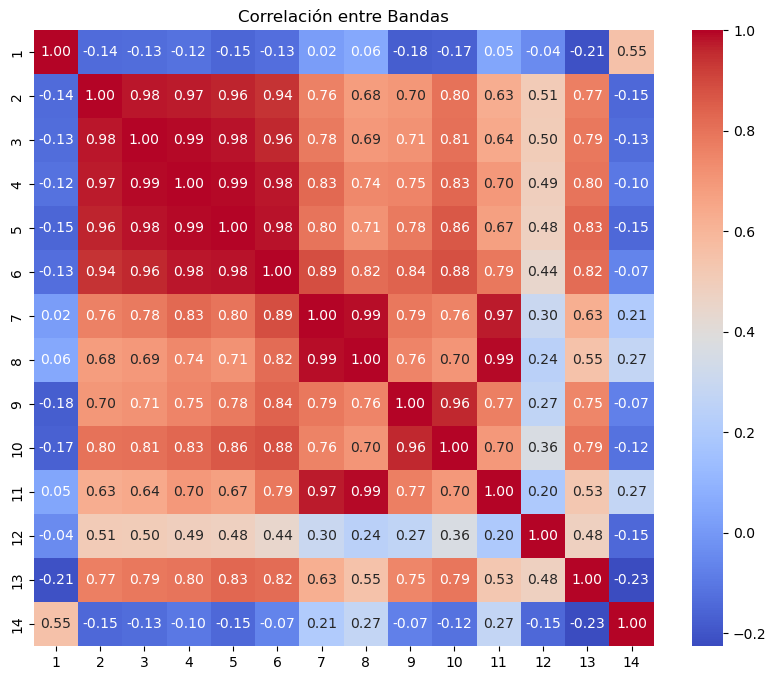

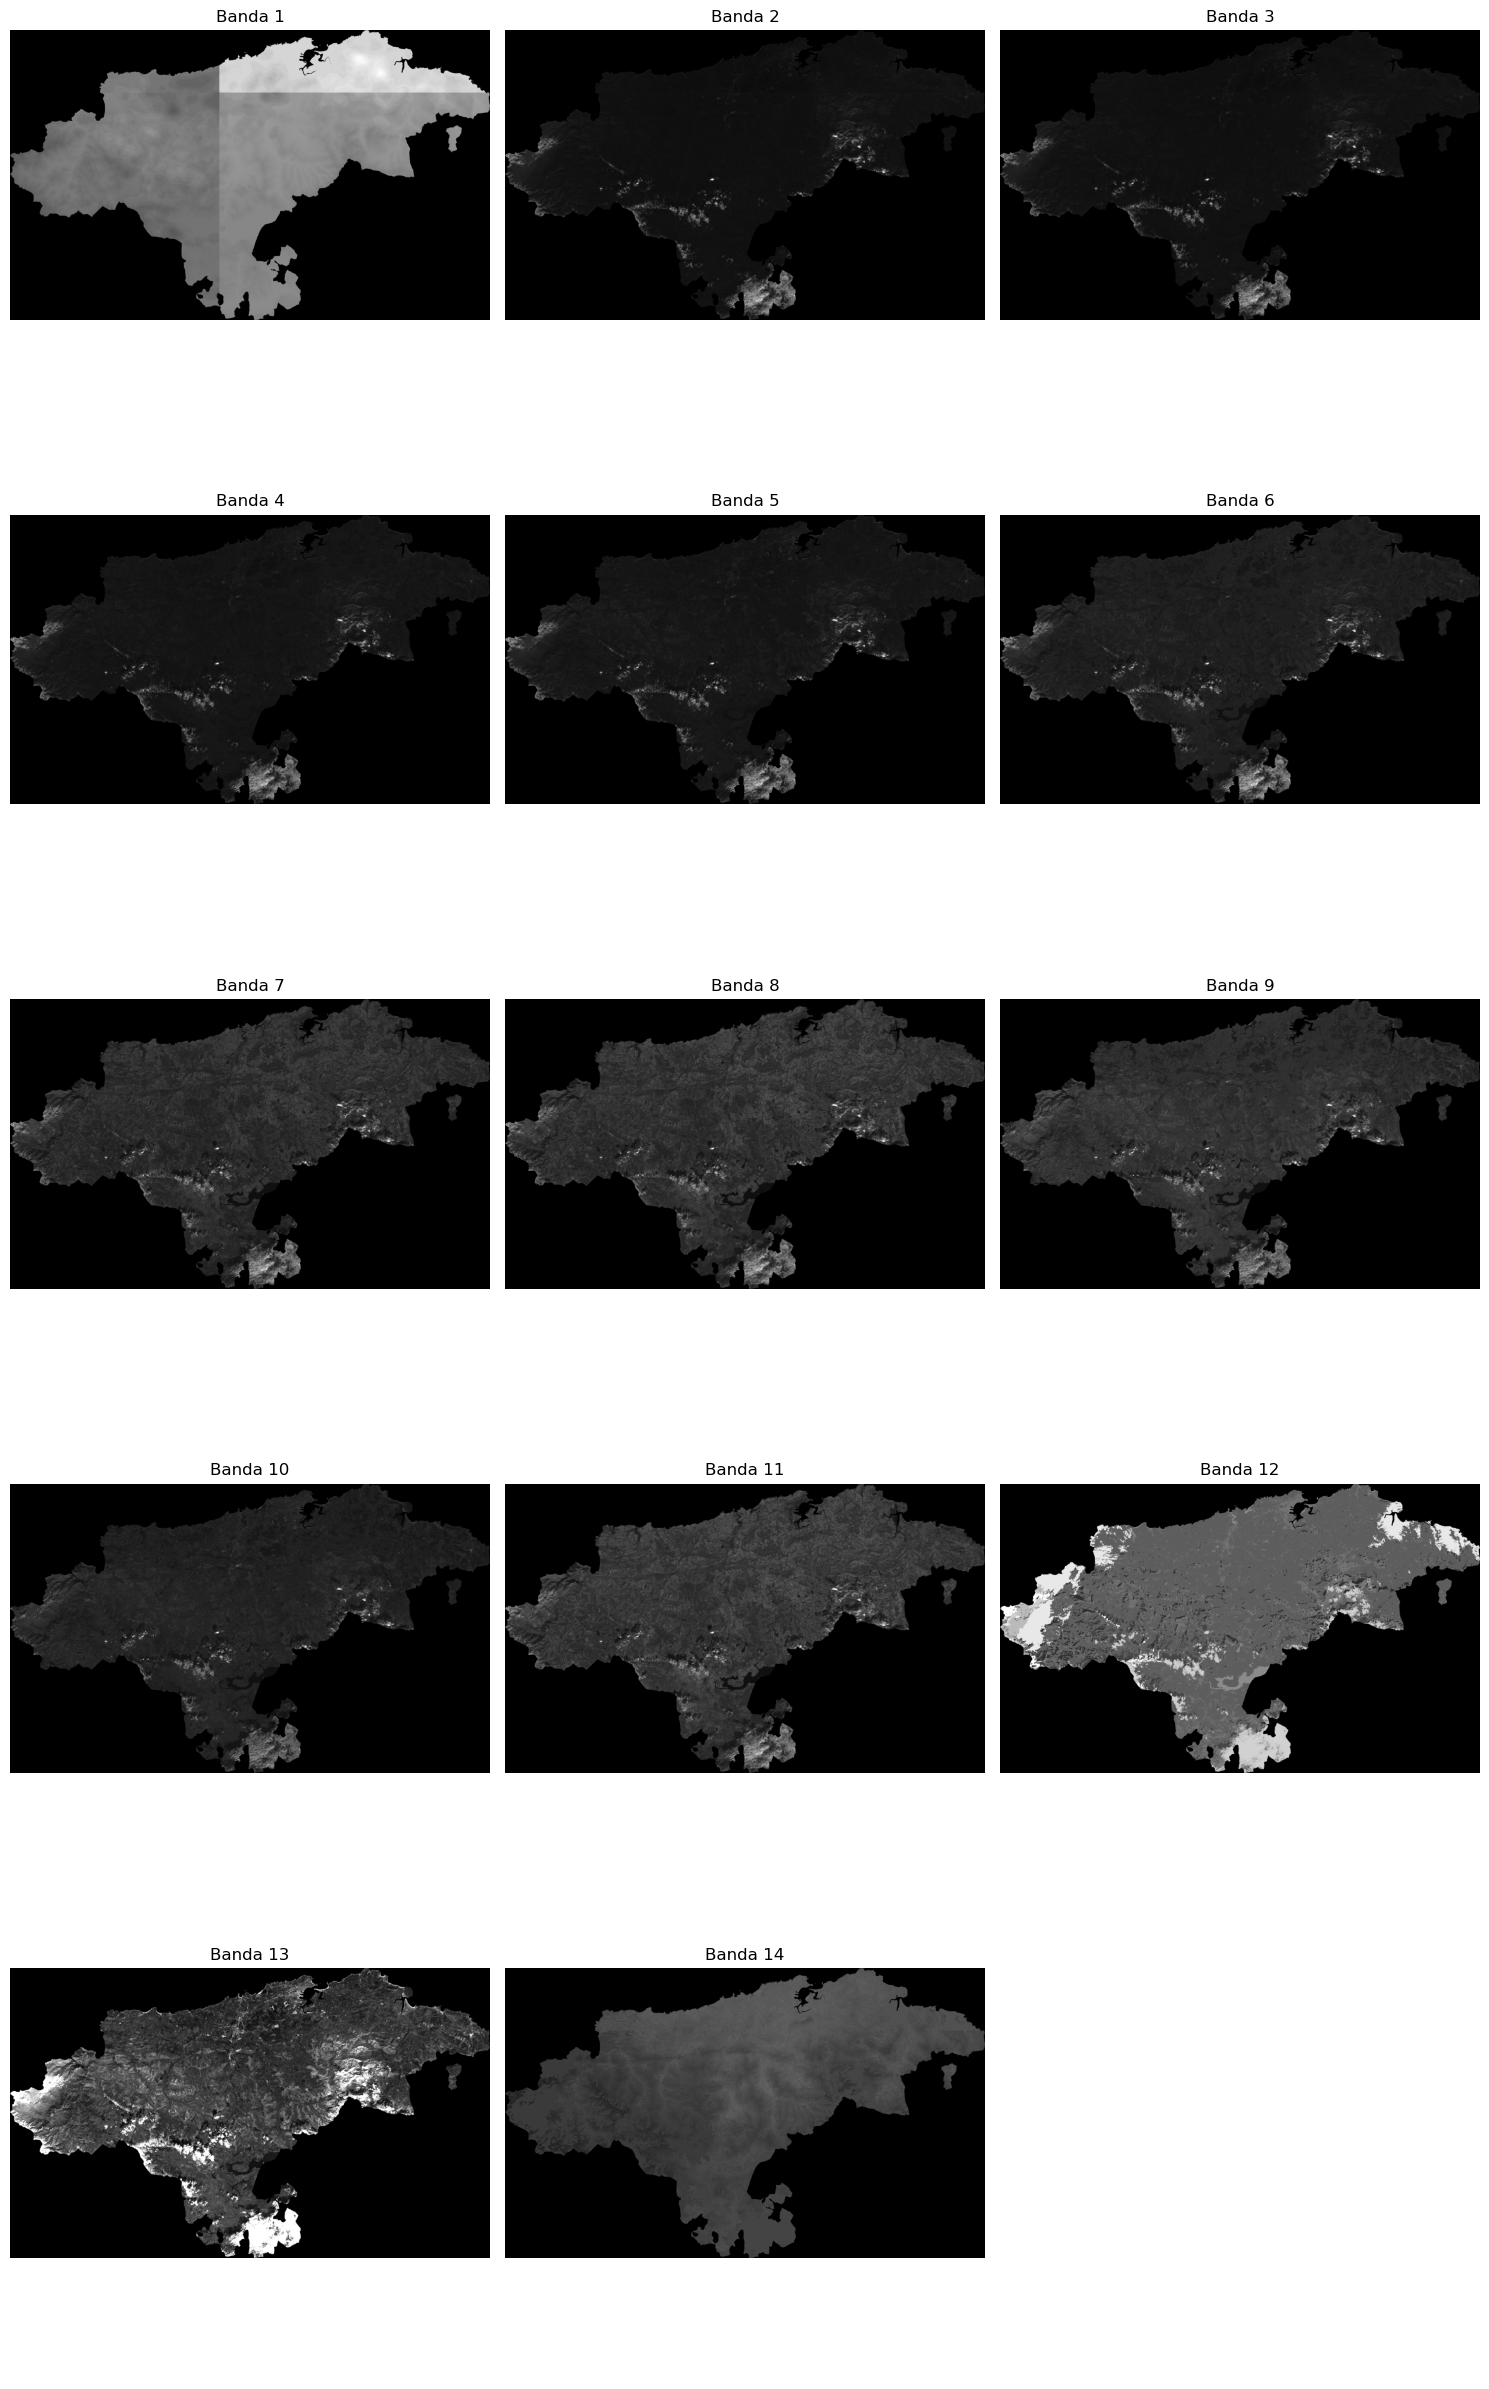

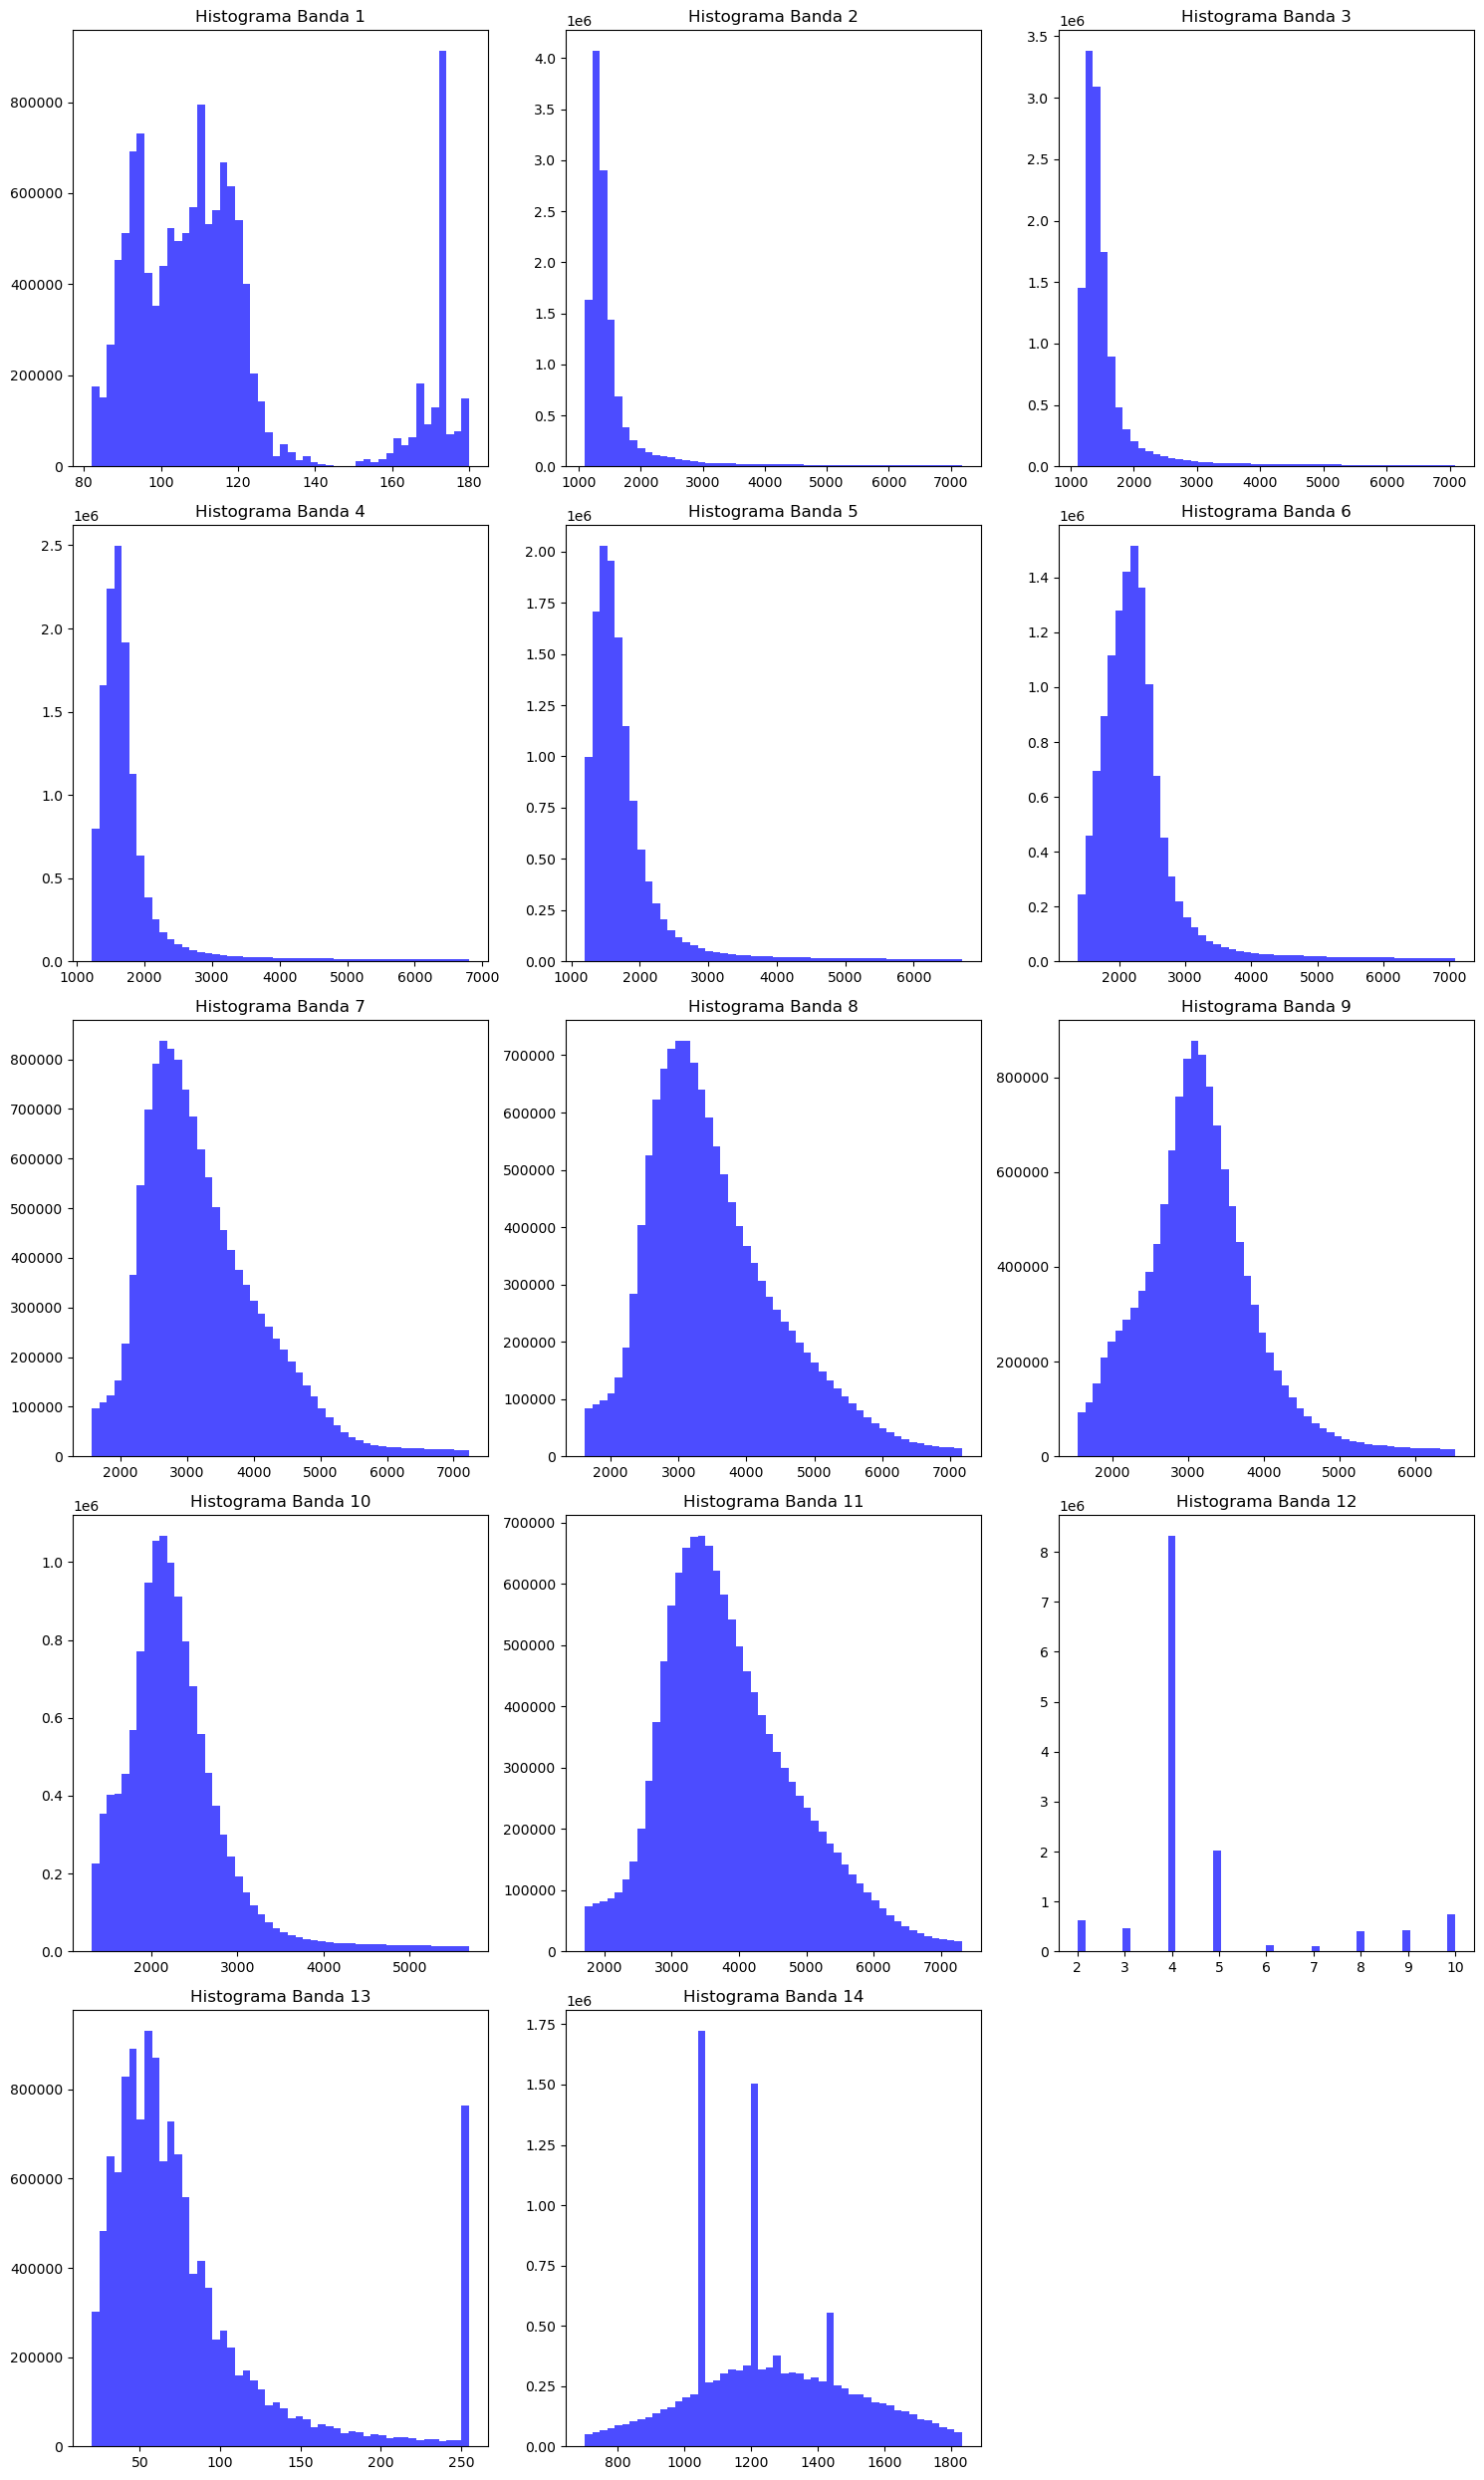

In [7]:
# ruta de la imagen anterior
output_path = sys.argv[1] + "resultados\\recorte_final.tif"

# Abrir la imagen y leer las bandas
with rasterio.open(output_path) as src:
    num_bandas = src.count  
    bandas = [src.read(i + 1) for i in range(num_bandas)]
    
#Estadisticas básicas:
stats = []
for i, banda in enumerate(bandas):
    valores_validos = banda[banda > 0]  # Excluir valores 0
    p2, p98 = np.percentile(valores_validos, [2, 98])  # Percentiles 2 y 98
    stats.append([i + 1, np.min(valores_validos), np.max(valores_validos), np.mean(valores_validos), np.std(valores_validos), p2, p98])

df_stats = pd.DataFrame(stats, columns=["Banda", "Mínimo", "Máximo", "Media", "Desviación estándar", "P2", "P98"])
print(df_stats)

# Matriz de correlación:
matriz_corr = np.corrcoef([banda[banda > 0].ravel() for banda in bandas])

plt.figure(figsize=(10, 8))
sns.heatmap(matriz_corr, annot=True, fmt=".2f", cmap="coolwarm", xticklabels=range(1, num_bandas+1), yticklabels=range(1, num_bandas+1))
plt.title("Correlación entre Bandas")
plt.show()


# Imagenes de las bandas en una matriz de 3 columnas y las filas necesarias.
fig, axes = plt.subplots((num_bandas // 3) + (num_bandas % 3 > 0), 3, figsize=(15, 5 * ((num_bandas // 3) + (num_bandas % 3 > 0))))
axes = axes.ravel()

for i in range(num_bandas):
    axes[i].imshow(bandas[i], cmap="gray")
    axes[i].set_title(f"Banda {i+1}")
    axes[i].axis("off")

# Para eliminar los huecos vacios de la ultima fila, en la hay menos de 3 graficos:
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

# Histogramas
fig, axes = plt.subplots((num_bandas // 3) + (num_bandas % 3 > 0), 3, figsize=(15, 5 * ((num_bandas // 3) + (num_bandas % 3 > 0))))
axes = axes.ravel()

for i in range(num_bandas):
    datos_validos = bandas[i][bandas[i] > 0]  # Ignorar ceros
    if datos_validos.size > 0:
        min_val, max_val = np.percentile(datos_validos, [2, 98])  # Usar percentiles 2 y 98
        axes[i].hist(datos_validos.ravel(), bins=50, color="blue", alpha=0.7, range=(min_val, max_val))
        axes[i].set_title(f"Histograma Banda {i+1}")

# Para los huecos vacios, de nuevo, en la ultima fiala:
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

En cuanto al metodo de cargar y generar los datos, ha sido un desafio el hecho de que aparecieran en imagenes individuales por cada banda lo cual nos ha supuesto tener que gestionar la conversion a multiimagen. 
Además nuestra zona de estudio ha sido en un punto en el que ha tocado generar un mosaico de imagenes. Esto es relativamente normal si tenemos en cuenta el tamaño de las imagenes que toma el satelite Sentinel 2A, y la extension de Cantabria. 
Por ultimo en este aspecto, hemos decidido recortar la imagen raster para limitarnos a analizar los datos que hay dentro de los limites de la comunidad, para poder compararlos con los datos en formato shapefile.

El uso de tkinter para elegir las rutas nos ha resultado provechoso ya que es practicamente igual a como se suelen introducir las rutas de carpetas o archivos en este tipo de herramientas.

En cuanto al analisis estadístico, podemos observar como algunas bandas tienen resultados algo extraños, por ejemplo, en la primera, que corresponde a la banda de aerosol, vemos unas lineas que diferencian los cuadrantes del mosaico, cosa que no ocurre en el restod e bandas. De todas formas esta es una banda con poca relevancia para la cuestion a estudiar, por lo que aunque la dejaremos, podemos obviarla.

A parte de esto, por el recorte que hemos hecho nos aparecian un numero enorme de valores 0, por lo que los hemos excluido del analisis estadístico. 
Finalmente, los histogramas aparecen como podriamos esperarlos, aunque en algunos puntos aparecen valores muy elevados como en las bandas 13 y 14, que pueden deberse a errores aunque habria que analizarlo con mas detenimiento.

## 1.2.- EDA de las tablas de datos en formato shape:

Ahora, vamos a empezar a tratar los datos, primero, hemos descargado de GBIF datos puntuales para toda España, vamos a tratarlos y luego los convertiremos en un geodato gracias a los datos de latitud y longitud.

In [8]:
eucpoints_tabla = pd.read_table(euc_points)

C:\Users\Edush\AppData\Local\Temp\ipykernel_6656\604695395.py:1: DtypeWarning: Columns (10,14,16,17,29,39,40,41,43,44,46,48) have mixed types. Specify dtype option on import or set low_memory=False.
  eucpoints_tabla = pd.read_table(euc_points)


Esto nos indica que la tabla tiene "mixed types", por lo cual, da problemas. Vamos a solucionarlo

In [9]:
eucpoints_tabla = pd.read_table(euc_points, low_memory=False)
print(eucpoints_tabla.dtypes)

gbifID                                int64
datasetKey                           object
occurrenceID                         object
kingdom                              object
phylum                               object
class                                object
order                                object
family                               object
genus                                object
species                              object
infraspecificEpithet                 object
taxonRank                            object
scientificName                       object
verbatimScientificName               object
verbatimScientificNameAuthorship     object
countryCode                          object
locality                             object
stateProvince                        object
occurrenceStatus                     object
individualCount                     float64
publishingOrgKey                     object
decimalLatitude                     float64
decimalLongitude                

Aquellas con el tipo "object" son las que representan tipos mixtos que dan problema, vamos a ver cuáles nos hacen falta y cuales podemos eliminar

In [10]:
eucpoints_tabla = eucpoints_tabla.drop(columns=["datasetKey", "occurrenceID", "infraspecificEpithet",
                                             "taxonRank", "scientificName", "verbatimScientificName", 
                                             "verbatimScientificNameAuthorship", "publishingOrgKey", 
                                             "eventDate", "basisOfRecord", "institutionCode", "collectionCode", 
                                             "catalogNumber", "recordNumber", "identifiedBy", "dateIdentified", 
                                             "license", "rightsHolder", "recordedBy", "establishmentMeans", 
                                             "mediaType", "issue", "locality", "typeStatus", "stateProvince", 
                                                "occurrenceStatus", "gbifID", "kingdom", "phylum", "class", "order", 
                                               "countryCode", "individualCount", "family", "elevationAccuracy", "depth",
                                               "lastInterpreted", "taxonKey", "speciesKey", "coordinateUncertaintyInMeters", 
                                               "coordinatePrecision", "depthAccuracy", "day", "month", "year"], errors="ignore")
eucpoints_tabla

,genus,species,decimalLatitude,decimalLongitude,elevation
0,Eucalyptus,NaN,NaN,NaN,NaN
1,Eucalyptus,Eucalyptus globulus,43.516539,-5.270636,157.00
2,Eucalyptus,Eucalyptus globulus,42.567851,-8.873670,80.38
3,Eucalyptus,Eucalyptus globulus,42.928194,-8.113348,489.00
4,Eucalyptus,Eucalyptus globulus,42.889623,-8.571294,393.00
...,...,...,...,...,...
178943,Eucalyptus,Eucalyptus reducta,NaN,NaN,NaN
178944,Eucalyptus,Eucalyptus globulus,39.779999,2.700000,1.00
178945,Eucalyptus,Eucalyptus globulus,39.770000,2.700000,1.00
178946,Eucalyptus,Eucalyptus globulus,NaN,NaN,NaN


Ahora vamos a eliminar aquellas que tengan vacía algunas de las coordenadas vacías

In [11]:
eucpoints_tabla["decimalLatitude"] = eucpoints_tabla["decimalLatitude"].replace("", np.nan)
eucpoints_tabla["decimalLongitude"] = eucpoints_tabla["decimalLongitude"].replace("", np.nan)

eucpoints_tabla = eucpoints_tabla.dropna(subset=["decimalLatitude", "decimalLongitude"])

eucpoints_tabla

,genus,species,decimalLatitude,decimalLongitude,elevation
1,Eucalyptus,Eucalyptus globulus,43.516539,-5.270636,157.00
2,Eucalyptus,Eucalyptus globulus,42.567851,-8.873670,80.38
3,Eucalyptus,Eucalyptus globulus,42.928194,-8.113348,489.00
4,Eucalyptus,Eucalyptus globulus,42.889623,-8.571294,393.00
5,Eucalyptus,Eucalyptus globulus,43.714230,-7.611280,NaN
...,...,...,...,...,...
178936,Eucalyptus,Eucalyptus camaldulensis,28.110870,-16.578650,530.00
178937,Eucalyptus,Eucalyptus camaldulensis,28.117600,-16.587020,705.00
178944,Eucalyptus,Eucalyptus globulus,39.779999,2.700000,1.00
178945,Eucalyptus,Eucalyptus globulus,39.770000,2.700000,1.00


Lo siguiente, será transformarlo a geodato para poder extraer solo aquellos que se encuentran dentro del shapefile de Cantabria

In [12]:
from shapely.geometry import Point
from pyproj import CRS

eucpoints = eucpoints_tabla.copy()
eucpoints["geometry"] = eucpoints.apply(
    lambda row: Point(row["decimalLongitude"], row["decimalLatitude"]), axis=1
)
crs = CRS("EPSG:4326")
gdf = gpd.GeoDataFrame(eucpoints, geometry="geometry", crs=crs)

gdf.columns = [col[:10] for col in gdf.columns]

print(gdf.head())
gdf.set_crs("EPSG:4326", inplace=True)


        genus              species  decimalLat  decimalLon  elevation  \
1  Eucalyptus  Eucalyptus globulus   43.516539   -5.270636     157.00   
2  Eucalyptus  Eucalyptus globulus   42.567851   -8.873670      80.38   
3  Eucalyptus  Eucalyptus globulus   42.928194   -8.113348     489.00   
4  Eucalyptus  Eucalyptus globulus   42.889623   -8.571294     393.00   
5  Eucalyptus  Eucalyptus globulus   43.714230   -7.611280        NaN   

                    geometry  
1  POINT (-5.27064 43.51654)  
2  POINT (-8.87367 42.56785)  
3  POINT (-8.11335 42.92819)  
4  POINT (-8.57129 42.88962)  
5  POINT (-7.61128 43.71423)  


,genus,species,decimalLat,decimalLon,elevation,geometry
1,Eucalyptus,Eucalyptus globulus,43.516539,-5.270636,157.00,POINT (-5.27064 43.51654)
2,Eucalyptus,Eucalyptus globulus,42.567851,-8.873670,80.38,POINT (-8.87367 42.56785)
3,Eucalyptus,Eucalyptus globulus,42.928194,-8.113348,489.00,POINT (-8.11335 42.92819)
4,Eucalyptus,Eucalyptus globulus,42.889623,-8.571294,393.00,POINT (-8.57129 42.88962)
5,Eucalyptus,Eucalyptus globulus,43.714230,-7.611280,NaN,POINT (-7.61128 43.71423)
...,...,...,...,...,...,...
178936,Eucalyptus,Eucalyptus camaldulensis,28.110870,-16.578650,530.00,POINT (-16.57865 28.11087)
178937,Eucalyptus,Eucalyptus camaldulensis,28.117600,-16.587020,705.00,POINT (-16.58702 28.1176)
178944,Eucalyptus,Eucalyptus globulus,39.779999,2.700000,1.00,POINT (2.7 39.78)
178945,Eucalyptus,Eucalyptus globulus,39.770000,2.700000,1.00,POINT (2.7 39.77)


In [13]:
print(gdf.crs)  # Verificar que el sistema de coordenadas es correcto

EPSG:4326


In [14]:
gdf.to_file( sys.argv[1]+"eucpoints.shp", driver="ESRI Shapefile", encoding="utf-8", engine="fiona")

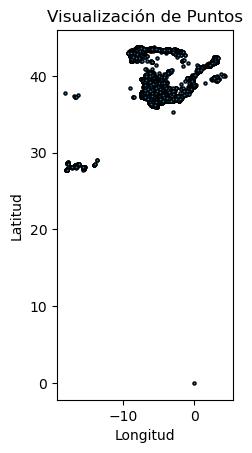

In [15]:

# Cargar el shapefile
geodato_prueba = gpd.read_file(sys.argv[1] + "eucpoints.shp")
# Visualizar
geodato_prueba.plot(markersize=5, edgecolor="black")
plt.title("Visualización de Puntos")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.show()


Ahora que lo hemos pasado a un archivo shapefile, vamos a extraer por la localización de cantabria concretamente.

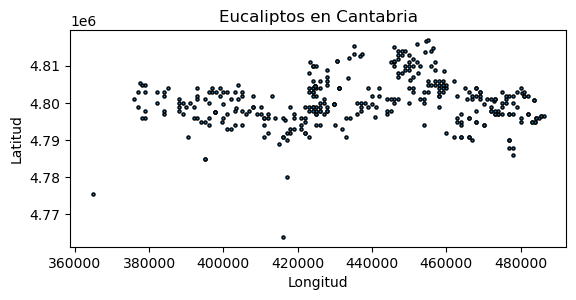

In [16]:
puntos_euc_españa = gpd.read_file(sys.argv[1] + "eucpoints.shp")
cantabria = gpd.read_file(sys.argv[1] + "shp_cantabria\\cantabria.shp")

# Comprobamos el SRC para cambiarlo por si fuera necesario.
if cantabria.crs != "EPSG:25830":
    cantabria = cantabria.to_crs(epsg=25830)

# Convertir puntos_euc_españa a EPSG:25830
eucaliptos = puntos_euc_españa.to_crs(epsg=25830)

# Usar clip para obtener solo los puntos dentro de Cantabria
eucal_cant = gpd.clip(eucaliptos, cantabria)

# Graficar los puntos resultantes
eucal_cant.plot(markersize=5, edgecolor="black")
plt.title("Eucaliptos en Cantabria")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.show()


y, como ha salido bien, vamos a guardar el geodato de eucaliptos de cantabria

In [17]:
eucal_cant.to_file(sys.argv[1]+"eucal_cant.shp", driver="ESRI Shapefile", encoding="utf-8", engine="fiona")

print(eucal_cant.crs)

EPSG:25830


Volvemos a cargar los datos relevantes y cargamos también los datos de eucaliptos del mapa forestal

In [8]:
eucal_cant = gpd.read_file(sys.argv[1] + "eucal_cant.shp")
euc_mfe_cant = gpd.read_file(sys.argv[1] + "Eucaliptales_Cornisa_Cantabrica\\Eucaliptales_Cornisa_Cantabrica.shp")
cantabria = gpd.read_file(sys.argv[1] + "shp_cantabria\\cantabria.shp")

C:\Users\angel\anaconda3\envs\advprog\lib\site-packages\pyogrio\core.py:36: RuntimeWarning: Could not detect PROJ data files.  Set PROJ_LIB environment variable to the correct path.
  _init_proj_data()


DataSourceError: -feucal_cant.shp: No such file or directory

In [19]:
eucal_cant

,genus,species,decimalLat,decimalLon,elevation,geometry
0,Eucalyptus,Eucalyptus globulus,43.118865,-4.661279,NaN,POINT (364851.922 4775354.135)
1,Eucalyptus,Eucalyptus globulus,43.208872,-4.291274,NaN,POINT (395107.05 4784819.375)
2,Eucalyptus,Eucalyptus globulus,43.208872,-4.291274,NaN,POINT (395107.05 4784819.375)
3,Eucalyptus,Eucalyptus globulus,43.262917,-4.350480,420.98,POINT (390394.463 4790897.316)
4,Eucalyptus,Eucalyptus globulus,43.290900,-4.281900,NaN,POINT (396008.177 4793917.334)
...,...,...,...,...,...,...
350,Eucalyptus,Eucalyptus globulus,43.484901,-3.539052,NaN,POINT (456409.81 4814805.63)
351,Eucalyptus,Eucalyptus globulus,43.485200,-3.667800,NaN,POINT (445998.906 4814914.295)
352,Eucalyptus,Eucalyptus globulus,43.494600,-3.593700,NaN,POINT (451998.399 4815912.846)
353,Eucalyptus,Eucalyptus globulus,43.501545,-3.561550,103.47,POINT (454602.986 4816666.108)


Debido a que parece que faltan muchos datos de elevación, vamos a hacer más hincapié en ello para ver si nos interesa borrar la columna y crear más adelante una relación espacial con el MDT

In [20]:
# Filtramos solo los registros donde no existe elevación
sin_elevacion = eucal_cant[eucal_cant["elevation"].isna()]

# Contamos los individuos por especie
conteo_especies = sin_elevacion["species"].value_counts()

# Convertimos a DataFrame para mostrarlo mejor
conteo_df = conteo_especies.reset_index()
conteo_df.columns = ["Especie", "Cantidad sin Elevación"]

# Ordenamos por cantidad descendente
conteo_df = conteo_df.sort_values(by="Cantidad sin Elevación", ascending=False)

# Mostrar tabla
print(conteo_df)


                    Especie  Cantidad sin Elevación
0       Eucalyptus globulus                     326
1  Eucalyptus camaldulensis                       2
2      Eucalyptus pulchella                       2
3         Eucalyptus nitens                       1


Debido a la ausencia de tantos datos de elevación, decidimos también eliminarla de la tabla

In [21]:
eucal_cant = eucal_cant.drop(columns=["elevation"])

Ahora vamos a observar la cantidad total de eucaliptos de cada especie. Hay que aclarar que la presencia indica que al menos hay uno.

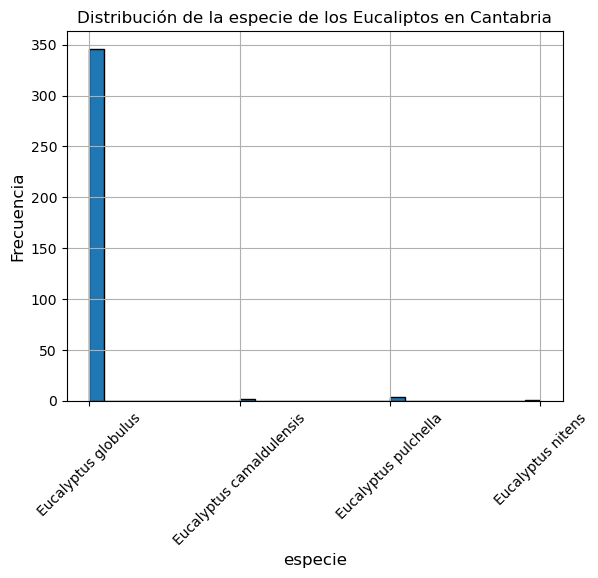

In [22]:
# Crear histograma de la columna de interés
eucal_cant["species"].hist(bins=30, edgecolor="black")

# Personalizar el gráfico
plt.title("Distribución de la especie de los Eucaliptos en Cantabria")
plt.xlabel("especie", fontsize=12)
plt.ylabel("Frecuencia", fontsize=12)
plt.xticks(fontsize=10, rotation=45)

plt.show()

Ahora vamos a ver los datos de eucaliptos del mapa forestal de España para cantabria:

In [23]:
euc_mfe_cant

,Poligon,ORIGEN,PRO_F,ccaa_F,ESTRATOIFN,Superficie,NUT2_NOM,NUT3_NOM,TipesTR25,DesTipEstr,...,UsoIFN,n_CLAMFE,UsoMFE,n_REGBIO,RegBio,LULUCF,Shape_Area,layer,path,geometry
0,115779,MFE25,33,12,10,0.465237,Principado de Asturias,Asturias,12,Bosque de Plantación,...,Monte arbolado. Bosque de plantaciones,112,Arbolado,2,Atlántica,111,4652.368141,Eucaliptales_Astures,C:\Users\jguil\Desktop\mfe\Eucaliptales_Asture...,"POLYGON ((165606.484 4816392.753, 165693.77 48..."
1,116006,MFE25,33,12,10,0.274108,Principado de Asturias,Asturias,12,Bosque de Plantación,...,Monte arbolado. Bosque de plantaciones,112,Arbolado,2,Atlántica,111,2741.080943,Eucaliptales_Astures,C:\Users\jguil\Desktop\mfe\Eucaliptales_Asture...,"POLYGON ((167591.977 4816495.528, 167591.973 4..."
2,116104,MFE25,33,12,09,1.739454,Principado de Asturias,Asturias,12,Bosque de Plantación,...,Monte arbolado. Bosque de plantaciones,112,Arbolado,2,Atlántica,111,17394.537537,Eucaliptales_Astures,C:\Users\jguil\Desktop\mfe\Eucaliptales_Asture...,"POLYGON ((163934.391 4816818.976, 163934.389 4..."
3,116260,MFE25,33,12,08,0.040862,Principado de Asturias,Asturias,12,Bosque de Plantación,...,Monte arbolado. Bosque de plantaciones,112,Arbolado,2,Atlántica,111,408.618738,Eucaliptales_Astures,C:\Users\jguil\Desktop\mfe\Eucaliptales_Asture...,"POLYGON ((163340.878 4817101.734, 163340.873 4..."
4,116425,MFE25,33,12,08,1.480848,Principado de Asturias,Asturias,12,Bosque de Plantación,...,Monte arbolado. Bosque de plantaciones,112,Arbolado,2,Atlántica,111,14808.478608,Eucaliptales_Astures,C:\Users\jguil\Desktop\mfe\Eucaliptales_Asture...,"POLYGON ((162116.806 4814938.064, 162100.631 4..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17911,14183892,MFE25,20,21,15,0.365187,País Vasco,Gipuzkoa,12,Bosque de Plantación,...,Monte arbolado. Bosque de plantaciones,112,Arbolado,2,Atlántica,111,3651.871712,Eucaliptales_Vascos,C:\Users\jguil\Desktop\mfe\Eucaliptales_Vascos...,"POLYGON ((586819.729 4797924.92, 586818.129 47..."
17912,14191017,MFE25,20,21,16,1.775191,País Vasco,Gipuzkoa,12,Bosque de Plantación,...,Monte arbolado. Bosque de plantaciones,112,Arbolado,2,Atlántica,111,17751.910807,Eucaliptales_Vascos,C:\Users\jguil\Desktop\mfe\Eucaliptales_Vascos...,"POLYGON ((587955.334 4785658.633, 587963.473 4..."
17913,14191018,MFE25,20,21,16,6.275164,País Vasco,Gipuzkoa,12,Bosque de Plantación,...,Monte arbolado. Bosque de plantaciones,112,Arbolado,2,Atlántica,111,62751.643097,Eucaliptales_Vascos,C:\Users\jguil\Desktop\mfe\Eucaliptales_Vascos...,"POLYGON ((586310.753 4785562.604, 586362.014 4..."
17914,14170188,MFE25,20,21,15,2.491701,País Vasco,Gipuzkoa,12,Bosque de Plantación,...,Monte arbolado. Bosque de plantaciones,112,Arbolado,2,Atlántica,111,24917.012035,Eucaliptales_Vascos,C:\Users\jguil\Desktop\mfe\Eucaliptales_Vascos...,"POLYGON ((556372.017 4788852.573, 556359.432 4..."


Como podemos observar, resulta que no son solo los de cantabria, por lo que lo que vamos a hacer es filtrar por los de la región de estudio, que coincide con la columna "NUT3_NOM"

In [24]:
euc_mfe_cant = euc_mfe_cant[euc_mfe_cant["NUT3_NOM"] == "Cantabria"]

euc_mfe_cant

,Poligon,ORIGEN,PRO_F,ccaa_F,ESTRATOIFN,Superficie,NUT2_NOM,NUT3_NOM,TipesTR25,DesTipEstr,...,UsoIFN,n_CLAMFE,UsoMFE,n_REGBIO,RegBio,LULUCF,Shape_Area,layer,path,geometry
2392,252888,MFE25,39,13,02,0.059789,Cantabria,Cantabria,12,Bosque de Plantación,...,Monte arbolado. Bosque de plantaciones,112,Arbolado,2,Atlántica,111,5.978893e+02,Eucaliptales_Cantabros,C:/Users/jguil/Desktop/mfe/Eucaliptales_Cantab...,"POLYGON ((376808.859 4795531.215, 376808.167 4..."
2393,252966,MFE25,39,13,02,0.208200,Cantabria,Cantabria,12,Bosque de Plantación,...,Monte arbolado. Bosque de plantaciones,112,Arbolado,2,Atlántica,111,2.082001e+03,Eucaliptales_Cantabros,C:/Users/jguil/Desktop/mfe/Eucaliptales_Cantab...,"POLYGON ((376792.163 4796557.079, 376786.877 4..."
2394,262070,MFE25,39,13,01,2.063254,Cantabria,Cantabria,12,Bosque de Plantación,...,Monte arbolado. Bosque de plantaciones,112,Arbolado,2,Atlántica,111,2.063254e+04,Eucaliptales_Cantabros,C:/Users/jguil/Desktop/mfe/Eucaliptales_Cantab...,"POLYGON ((376118.302 4802814.211, 376079.183 4..."
2395,272145,MFE25,39,13,01,133.896730,Cantabria,Cantabria,12,Bosque de Plantación,...,Monte arbolado. Bosque de plantaciones,112,Arbolado,2,Atlántica,111,1.338967e+06,Eucaliptales_Cantabros,C:/Users/jguil/Desktop/mfe/Eucaliptales_Cantab...,"POLYGON ((377397.421 4800004.568, 377399.782 4..."
2396,272149,MFE25,39,13,01,23.725829,Cantabria,Cantabria,12,Bosque de Plantación,...,Monte arbolado. Bosque de plantaciones,112,Arbolado,2,Atlántica,111,2.372583e+05,Eucaliptales_Cantabros,C:/Users/jguil/Desktop/mfe/Eucaliptales_Cantab...,"POLYGON ((376108.881 4800574.938, 376109.561 4..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4107,406502,MFE25,39,13,03,1.316862,Cantabria,Cantabria,12,Bosque de Plantación,...,Monte con arbolado ralo. Bosque de plantaciones,122,Arbolado ralo,2,Atlántica,112,1.316862e+04,Eucaliptales_Cantabros,C:/Users/jguil/Desktop/mfe/Eucaliptales_Cantab...,"POLYGON ((406728.418 4797344.683, 406708.351 4..."
4108,441326,MFE25,39,13,01,262.878941,Cantabria,Cantabria,12,Bosque de Plantación,...,Monte arbolado. Bosque de plantaciones,112,Arbolado,2,Atlántica,111,2.628789e+06,Eucaliptales_Cantabros,C:/Users/jguil/Desktop/mfe/Eucaliptales_Cantab...,"POLYGON ((405132.056 4804865.337, 405139.652 4..."
4109,441335,MFE25,39,13,03,15.146864,Cantabria,Cantabria,12,Bosque de Plantación,...,Monte arbolado. Bosque de plantaciones,112,Arbolado,2,Atlántica,111,1.514686e+05,Eucaliptales_Cantabros,C:/Users/jguil/Desktop/mfe/Eucaliptales_Cantab...,"POLYGON ((406591.581 4803871.661, 406638.617 4..."
4110,442899,MFE25,39,13,01,217.759402,Cantabria,Cantabria,12,Bosque de Plantación,...,Monte arbolado. Bosque de plantaciones,112,Arbolado,2,Atlántica,111,2.177594e+06,Eucaliptales_Cantabros,C:/Users/jguil/Desktop/mfe/Eucaliptales_Cantab...,"POLYGON ((406190.541 4805399.105, 406180.187 4..."


y, como hicimos antes vamos a eliminar las columnas que creamos que no nos sirven:

In [25]:
print(euc_mfe_cant.columns)

Index(['Poligon', 'ORIGEN', 'PRO_F', 'ccaa_F', 'ESTRATOIFN', 'Superficie',
       'NUT2_NOM', 'NUT3_NOM', 'TipesTR25', 'DesTipEstr', 'FCCARB', 'FORARB',
       'FormArbol', 'n_distribu', 'Distribuci', 'n_sp1', 'Especie1', 'O1',
       'n_estado1', 'Estado1', 'n_sp2', 'Especie2', 'O2', 'n_estado2',
       'Estado2', 'n_sp3', 'Especie3', 'O3', 'n_estado3', 'Estado3', 'FCCMAT',
       'n_FORmat', 'FormArbust', 'HMMAT', 'FCCHER', 'n_FORHER', 'FormHerbac',
       'n_ATRIBUTO', 'atributo', 'FCCTOT', 'n_MODCOM', 'ModeloComb',
       'TIPOBOSQUE', 'n_CLAIFN', 'UsoIFN', 'n_CLAMFE', 'UsoMFE', 'n_REGBIO',
       'RegBio', 'LULUCF', 'Shape_Area', 'layer', 'path', 'geometry'],
      dtype='object')


In [26]:
euc_polyg = euc_mfe_cant.drop(columns=["Poligon", "ESTRATOIFN", "ORIGEN", "PRO_F", "ccaa_F", 
                                       "NUT2_NOM", "NUT3_NOM", "FCCARB", "FORARB","path", "layer",
                                      "Shape_Area", "ModeloComb", "Superficie", "n_sp1", "n_estado1",
                                      "TipesTR25", "O1", "n_sp2", "n_estado2", "n_MODCOM", "O2", "Estado2", 
                                       "Especie3", "n_sp3", "FCCTOT", "n_CLAIFN", "O3", "n_estado3", "n_ATRIBUTO",
                                      "Estado3", "FCCMAT", "n_FORmat", "n_distribu", "HMMAT", "FCCHER", "atributo",
                                      "n_FORHER", "FormHerbac", "n_CLAMFE", "LULUCF" ])
euc_polyg

,DesTipEstr,FormArbol,Distribuci,Especie1,Estado1,Especie2,FormArbust,TIPOBOSQUE,UsoIFN,UsoMFE,n_REGBIO,RegBio,geometry
2392,Bosque de Plantación,Eucaliptales,Uniforme,Eucalyptus globulus,Fustal,Eucalyptus globulus,"Tojares mixtos (incluyendo tojo-brezales, tojo...",Frondosas,Monte arbolado. Bosque de plantaciones,Arbolado,2,Atlántica,"POLYGON ((376808.859 4795531.215, 376808.167 4..."
2393,Bosque de Plantación,Eucaliptales,Uniforme,Eucalyptus globulus,Latizal,Quercus robur,"Orlas, espinares mesófilos mixtos y afines (do...",Frondosas,Monte arbolado. Bosque de plantaciones,Arbolado,2,Atlántica,"POLYGON ((376792.163 4796557.079, 376786.877 4..."
2394,Bosque de Plantación,Eucaliptales,Uniforme,Eucalyptus globulus,Fustal,sin datos,"Orlas, espinares mesófilos mixtos y afines (do...",Frondosas,Monte arbolado. Bosque de plantaciones,Arbolado,2,Atlántica,"POLYGON ((376118.302 4802814.211, 376079.183 4..."
2395,Bosque de Plantación,Eucaliptales,Uniforme,Eucalyptus globulus,Fustal,Castanea sativa,"Orlas, espinares mesófilos mixtos y afines (do...",Frondosas,Monte arbolado. Bosque de plantaciones,Arbolado,2,Atlántica,"POLYGON ((377397.421 4800004.568, 377399.782 4..."
2396,Bosque de Plantación,Eucaliptales,Uniforme,Eucalyptus globulus,Fustal,Castanea sativa,"Orlas, espinares mesófilos mixtos y afines (do...",Frondosas,Monte arbolado. Bosque de plantaciones,Arbolado,2,Atlántica,"POLYGON ((376108.881 4800574.938, 376109.561 4..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4107,Bosque de Plantación,Eucaliptales,Uniforme,Eucalyptus globulus,Monte bravo,sin datos,"Tojares mixtos (incluyendo tojo-brezales, tojo...",Frondosas,Monte con arbolado ralo. Bosque de plantaciones,Arbolado ralo,2,Atlántica,"POLYGON ((406728.418 4797344.683, 406708.351 4..."
4108,Bosque de Plantación,Eucaliptales,Uniforme,Eucalyptus globulus,Fustal,Quercus robur,"Orlas, espinares mesófilos mixtos y afines (do...",Frondosas,Monte arbolado. Bosque de plantaciones,Arbolado,2,Atlántica,"POLYGON ((405132.056 4804865.337, 405139.652 4..."
4109,Bosque de Plantación,Eucaliptales,Uniforme,Eucalyptus globulus,Monte bravo,sin datos,"Orlas, espinares mesófilos mixtos y afines (do...",Frondosas,Monte arbolado. Bosque de plantaciones,Arbolado,2,Atlántica,"POLYGON ((406591.581 4803871.661, 406638.617 4..."
4110,Bosque de Plantación,Eucaliptales,Uniforme,Eucalyptus globulus,Fustal,Quercus robur,"Orlas, espinares mesófilos mixtos y afines (do...",Frondosas,Monte arbolado. Bosque de plantaciones,Arbolado,2,Atlántica,"POLYGON ((406190.541 4805399.105, 406180.187 4..."


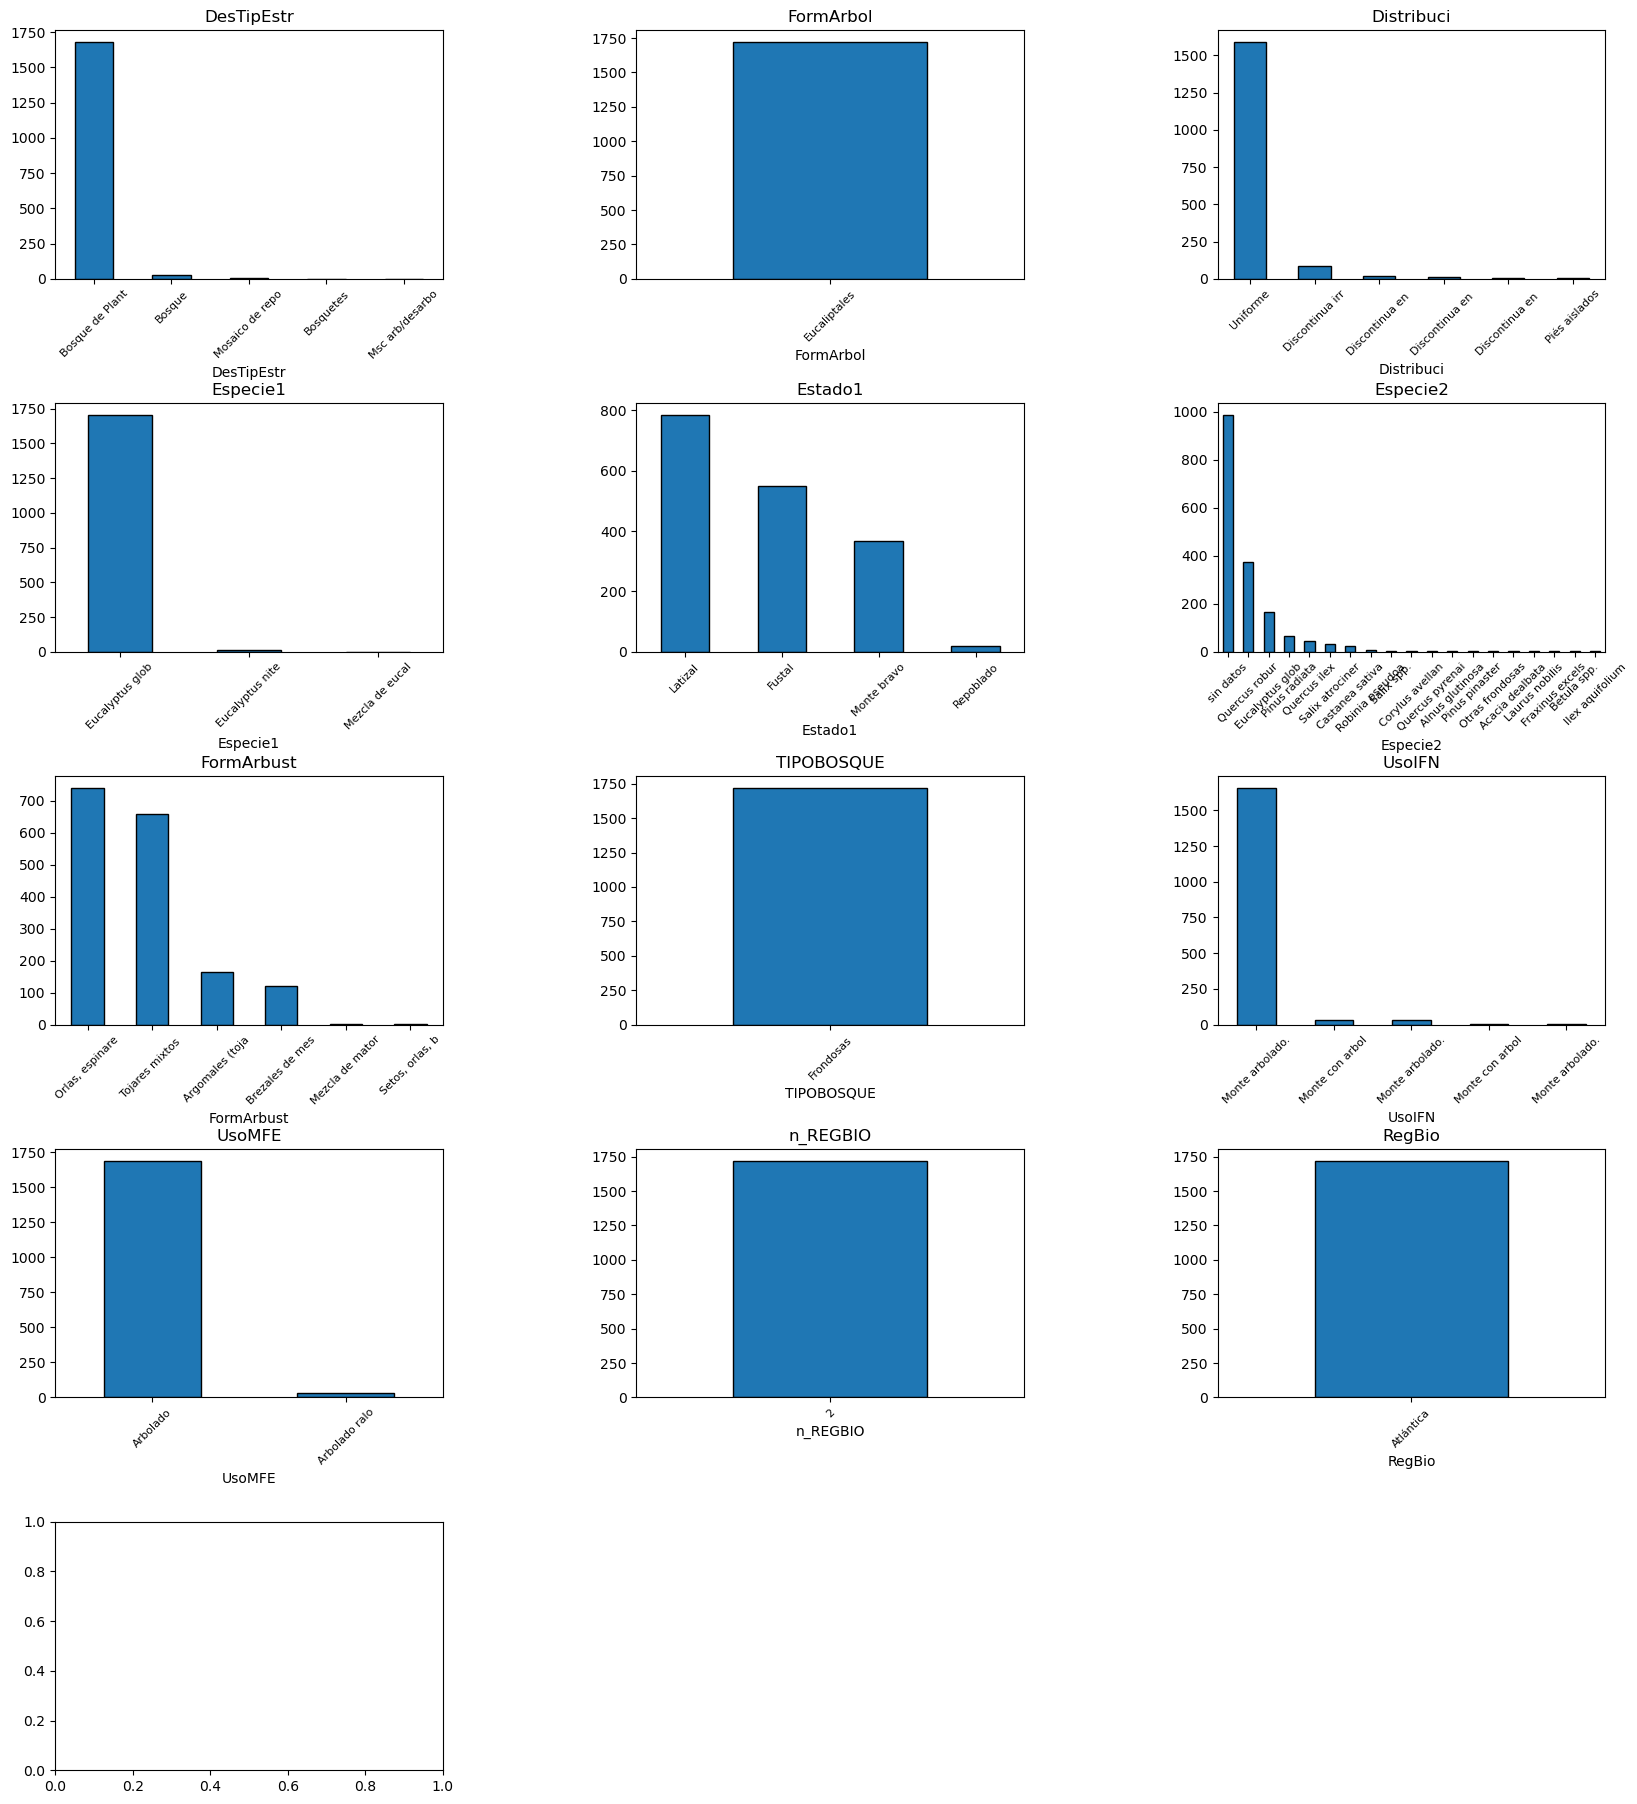

In [27]:
# Creamos la matriz para los histogramas, con 3 columnas.
num_cols = len(euc_polyg.columns)
num_rows = math.ceil(num_cols / 3) 
fig, axes = plt.subplots(nrows=num_rows, ncols=3, figsize=(20, num_rows * 6))
axes = axes.flatten()

# Creamos los histogramas
for i, columna in enumerate(euc_polyg.columns):
    if euc_polyg[columna].dtype in ['float64', 'int64', 'object']:
        #  Pasamos todos los valores a cadena antes de acortarlos
        euc_polyg[columna].value_counts().rename(lambda x: str(x)[:15]).plot(kind='bar', ax=axes[i], edgecolor="black")
        axes[i].set_title(columna, fontsize=12)
        axes[i].tick_params(axis='x', labelrotation=45, labelsize=8)
        axes[i].tick_params(axis='y', labelsize=10)

# Eliminar ejes vacios en la fila final
for i in range(len(euc_polyg.columns), len(axes)):
    fig.delaxes(axes[i])

#  Aumentar espacio entre filas, columnas y en la parte inferior para mejorar la visualización.
plt.subplots_adjust(hspace=0.5, wspace=0.5, bottom=0.3) 

plt.show()

Con esta exploración de datos, llegamos a la conclusión de borrar también las columnas siguientes: "UsoMFE", "TIPOBOSQUE", "FormArbol", "Especie1", "n_REGBIO", "RegBio" por ser prácticamente datos únicos.

In [28]:
euc_polyg = euc_mfe_cant.drop(columns=["Poligon", "ESTRATOIFN", "ORIGEN", "PRO_F", "ccaa_F", 
                                       "NUT2_NOM", "NUT3_NOM", "FCCARB", "FORARB","path", "layer",
                                      "Shape_Area", "ModeloComb", "Superficie", "n_sp1", "n_estado1",
                                      "TipesTR25", "O1", "n_sp2", "n_estado2", "n_MODCOM", "O2", "Estado2", 
                                       "Especie3", "n_sp3", "FCCTOT", "n_CLAIFN", "O3", "n_estado3", "n_ATRIBUTO",
                                      "Estado3", "FCCMAT", "n_FORmat", "n_distribu", "HMMAT", "FCCHER", "atributo",
                                      "n_FORHER", "FormHerbac", "n_CLAMFE", "LULUCF", "UsoMFE", "TIPOBOSQUE", 
                                       "FormArbol", "Especie1", "n_REGBIO", "RegBio" ])
euc_polyg

,DesTipEstr,Distribuci,Estado1,Especie2,FormArbust,UsoIFN,geometry
2392,Bosque de Plantación,Uniforme,Fustal,Eucalyptus globulus,"Tojares mixtos (incluyendo tojo-brezales, tojo...",Monte arbolado. Bosque de plantaciones,"POLYGON ((376808.859 4795531.215, 376808.167 4..."
2393,Bosque de Plantación,Uniforme,Latizal,Quercus robur,"Orlas, espinares mesófilos mixtos y afines (do...",Monte arbolado. Bosque de plantaciones,"POLYGON ((376792.163 4796557.079, 376786.877 4..."
2394,Bosque de Plantación,Uniforme,Fustal,sin datos,"Orlas, espinares mesófilos mixtos y afines (do...",Monte arbolado. Bosque de plantaciones,"POLYGON ((376118.302 4802814.211, 376079.183 4..."
2395,Bosque de Plantación,Uniforme,Fustal,Castanea sativa,"Orlas, espinares mesófilos mixtos y afines (do...",Monte arbolado. Bosque de plantaciones,"POLYGON ((377397.421 4800004.568, 377399.782 4..."
2396,Bosque de Plantación,Uniforme,Fustal,Castanea sativa,"Orlas, espinares mesófilos mixtos y afines (do...",Monte arbolado. Bosque de plantaciones,"POLYGON ((376108.881 4800574.938, 376109.561 4..."
...,...,...,...,...,...,...,...
4107,Bosque de Plantación,Uniforme,Monte bravo,sin datos,"Tojares mixtos (incluyendo tojo-brezales, tojo...",Monte con arbolado ralo. Bosque de plantaciones,"POLYGON ((406728.418 4797344.683, 406708.351 4..."
4108,Bosque de Plantación,Uniforme,Fustal,Quercus robur,"Orlas, espinares mesófilos mixtos y afines (do...",Monte arbolado. Bosque de plantaciones,"POLYGON ((405132.056 4804865.337, 405139.652 4..."
4109,Bosque de Plantación,Uniforme,Monte bravo,sin datos,"Orlas, espinares mesófilos mixtos y afines (do...",Monte arbolado. Bosque de plantaciones,"POLYGON ((406591.581 4803871.661, 406638.617 4..."
4110,Bosque de Plantación,Uniforme,Fustal,Quercus robur,"Orlas, espinares mesófilos mixtos y afines (do...",Monte arbolado. Bosque de plantaciones,"POLYGON ((406190.541 4805399.105, 406180.187 4..."


Finalmente, vamos a guardar los resultados de la limpieza de datos en la carpeta de resultados, ya que estos son los datos con los que vamos a trabajar. Se asume que estos geodatos son de eucaliptos o eucaliptales (diferencia de si es punto o polígono) en cantabria, por tanto un clima atlántico:

In [29]:
euc_polyg = euc_polyg.to_file(sys.argv[1]+"resultados\\euc_polyg.shp", driver="ESRI Shapefile", encoding="utf-8", engine="fiona")

euc_points = eucal_cant.to_file(sys.argv[1]+"resultados\\euc_points.shp", driver="ESRI Shapefile", encoding="utf-8", engine="fiona")



Ahora vamos a realizar una correlación entre variables cualitativas, hemos escogido la segunda especie más abundante "Especie2" y la formación arbustiva "FormArbust", del mapa forestal. Para ello hemos realizado la correlación Chi-cuadrado de Cramer:

In [3]:
import pandas as pd
import numpy as np
import scipy.stats as stats

# Función para calcular indice de correlacion de cramer
def cramers_v(x, y):
    """Calcula la correlación entre dos variables categóricas."""
    tabla = pd.crosstab(x, y)  # Crea una tabla de frecuencia
    chi2 = stats.chi2_contingency(tabla_contingencia)[0]  # Calcula Chi-cuadrado
    n = tabla_contingencia.sum().sum()  # Total de observaciones
    phi2 = chi2 / n
    r, k = tabla.shape
    return np.sqrt(phi2 / min(r - 1, k - 1))

# Calcular la correlación entre 'Especie2' y 'FormArbust'
cramers_v_value = cramers_v(euc_polyg["Especie2"], euc_polyg["FormArbust"])
print(f"Correlación de Cramer entre Especie2 y FormArbust: {cramers_v_value:.4f}")

NameError: name 'euc_polyg' is not defined

El resultado es una correlación moderada. (baja de 0 a 0.1, media de 0.1 a 0.3 y alta si es más de 0.3)

In [32]:
print(pd.crosstab(euc_polyg["Especie2"], euc_polyg["FormArbust"]))

TypeError: 'NoneType' object is not subscriptable

Hay que revisar:

El ultimo histograma esta vacio.

Los ultimas dos celdas dan error...


En estos datos que, como ya se ha dicho, son exclusivamente de eucaliptales en cantabria, encontramos una limitación bastante grande para un análisis no espacial.

Esto es porque, al no poder tener en cuenta para el EDA inicial su contexto espacial, solo podemos tener en cuenta los datos secundarios que los acompañan como "Especie2" que es la segunda especie con mayor presencia en el polígono en caso del mapa forestal de España o la "FormArbus" también en este mapa forestal y algunos más, no así en el conteo de puntos, que hay muy pocos datos más allá de la ubicación. Se podría hacer más hincapié en la especie de eucalipto, pero la dominancia del Globulus es más que decisiva.

Por lo pronto vemos como el shp del mapa forestal, que tiene más datos y con el que hemos realizado la serie de histogramas y la correlación de Cramer (que vimos que hay relación media), indica que los polígonos de eucaliptos son principalmente bosques de plantación, de especie Eucalytus globulus, distribución uniforme y, con más variedad, predominan en estado de la vegetación latizales, en especies secundarias predomina la ausencia de datos y, en segundo lugar, el Quercus robur. Además en la forma de la vegetación arbustiva, predominan "Orlas, espinares mesófilos mixtos y afines (dom. Rosaceae)" seguidos muy cerca de los "Tojares mixtos"

Más adelante se asociarán estas ubicaciones a características espaciales que, ahora mismo, no conviene hacer por el objetivo de esta parte, pero que darán mucha riqueza a los datos, siendo, por tanto, una fuerte limitación en esta parte del estudio.